In [211]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import trange,tqdm
sys.path.append('./include')
import ml4s
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s._set_css_style('./include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime
import cv2
import cv2 as cv
from matplotlib import gridspec

In [212]:
# load the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)
# determine the properties
rows,cols = x_train[0].shape
num_classes = 10

# reshape and rescale
x_train = x_train.reshape(x_train.shape[0], rows*cols).astype('float32')/255
x_test = x_test.reshape(x_test.shape[0], rows*cols).astype('float32')/255
print(x_train.shape)
# use a built-in function to get 1-hot encoding
y_train_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_hot = keras.utils.to_categorical(y_test, num_classes)
print(rows,cols)

(60000, 28, 28)
(60000, 784)
28 28


class: 3
1-hot: [0 0 0 1 0 0 0 0 0 0]


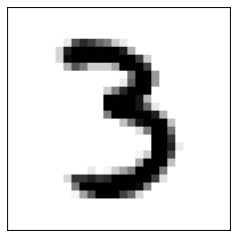

In [213]:
# get a random digit in the training set
idx = np.random.randint(low=0, high=len(x_train))

print(f'class: {y_train[idx]}')
print(f'1-hot: {y_train_hot[idx].astype(int)}')

plt.matshow(x_train[idx,:].reshape(rows,cols), cmap='binary')
plt.xticks([]);
plt.yticks([]);

In [214]:
def plot_digit_array(x,y, show_prediction=False):
    '''Expects a list of digits (x) and associated labels (y)'''
    
    # determine the number of rows and columns of our image array
    num_digits = x.shape[0]
    num_cols = int(np.sqrt(num_digits))
    num_rows = num_digits//num_cols + 1

    fig,ax = plt.subplots(nrows=num_rows,ncols=num_cols,sharex=True,sharey=True,
                          figsize=(num_cols,num_rows))
    
    # plot all the numbers
    for i,cax in enumerate(ax.flatten()):
        if i < num_digits:
            cax.matshow(x[i].reshape(28,28), cmap='binary')
            cax.axis('off')
            if show_prediction:
                cax.text(0.99,0.99,f'{y[i]}',horizontalalignment='right',verticalalignment='top', 
                         transform=cax.transAxes, fontsize=8, color='r')
        else:
            cax.axis('off')

CPU times: user 8.22 s, sys: 38 ms, total: 8.26 s
Wall time: 8.3 s


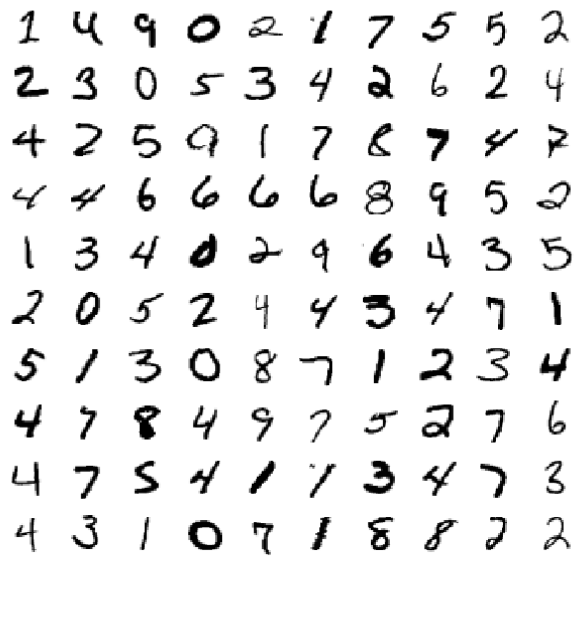

In [215]:
%%time
idx = np.random.randint(low=0, high=x_train.shape[0], size=100)
plot_digit_array(x_train[idx],y_train[idx])

In [216]:
model = keras.Sequential(
[
    layers.Dense(128,input_shape=(rows*cols,),activation='relu'),
    layers.Dense(128,input_shape=(rows*cols,),activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [217]:
batch_size = 32
epochs = 5

training = model.fit(x_train,y_train_hot, batch_size=batch_size, epochs=epochs,
                     verbose=1, validation_data=(x_test,y_test_hot))

Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4069 - accuracy: 0.8827 - val_loss: 0.1159 - val_accuracy: 0.9642
Epoch 2/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1011 - accuracy: 0.9692 - val_loss: 0.0987 - val_accuracy: 0.9686
Epoch 3/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0619 - accuracy: 0.9802 - val_loss: 0.0776 - val_accuracy: 0.9756
Epoch 4/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0468 - accuracy: 0.9854 - val_loss: 0.0736 - val_accuracy: 0.9770
Epoch 5/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0356 - accuracy: 0.9889 - val_loss: 0.0817 - val_accuracy: 0.9781


In [218]:
predictions_prob_train = model(x_train)
predictions_prob_test = model(x_test)

predictions_train = np.argmax(predictions_prob_train,axis=1)
predictions_test = np.argmax(predictions_prob_test,axis=1)

mistakes_train = np.where(predictions_train != y_train)[0]
mistakes_test = np.where(predictions_test != y_test)[0]

num_mistakes_train,num_mistakes_test = len(mistakes_train),len(mistakes_test)

print(f'Train Mistakes: {100*num_mistakes_train/x_train.shape[0]:.2f}%')
print(f'Test Mistakes : {100*num_mistakes_test/x_test.shape[0]:.2f}%')

Train Mistakes: 0.97%
Test Mistakes : 2.19%


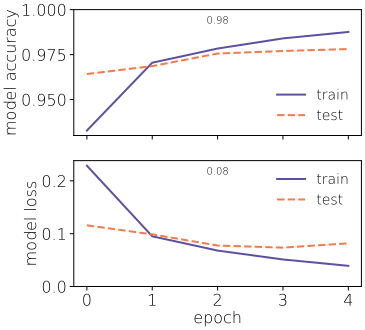

In [219]:
# look into training history
fig,ax = plt.subplots(2,1, sharex=True, figsize=(5,5))

score = model.evaluate(x_test, y_test_hot, verbose=0);

# accuracy
ax[0].plot(training.history['accuracy'], color=colors[0])
ax[0].plot(training.history['val_accuracy'], ls='--', color=colors[-3])
ax[0].set_ylabel('model accuracy')
ax[0].legend(['train', 'test'], loc='best')
ax[0].text(0.5,0.95,f'{score[1]:.2f}',horizontalalignment='center',verticalalignment='top', 
                         transform=ax[0].transAxes)
ax[0].set_ylim(top=1)

# loss
ax[1].plot(training.history['loss'], color=colors[0])
ax[1].plot(training.history['val_loss'], ls='--', color=colors[-3])
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].set_ylim(bottom=0)
ax[1].text(0.5,0.95,f'{score[0]:.2f}',horizontalalignment='center',verticalalignment='top', 
                         transform=ax[1].transAxes)
ax[1].legend(['train', 'test'], loc='best');

# There is an error somewhere that I can't find. Seems like the prediction array from my model is not getting pushed to the graph and prediction number. Not sure for what image it's displaying that for but I can't find it

tf.Tensor(
[[6.6223675e-03 7.6777933e-14 2.2740790e-07 7.0439464e-01 4.3299555e-14 9.9081756e-04 2.8799096e-01 4.3061277e-07
  6.0542538e-07 4.2781254e-09]], shape=(1, 10), dtype=float32)


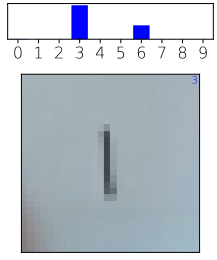

In [232]:
img1 = cv.imread('img1.jpeg')
img_1 = cv.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img_1 = img_1.reshape(1, rows*cols).astype('float32')/255

prediction = model(img_1)
print(prediction)

fig = plt.figure(figsize=(3,1.2*3),constrained_layout=True) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5], figure=fig) 

ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]

ax[0].bar(range(num_classes),prediction[0,:], color='b')
ax[0].set_xticks(range(num_classes))
ax[0].set_yticks([]);
ax[0].set_xlim(-0.5,9.5)

ax[1].matshow(img_1, cmap='binary')

ax[1].text(0.99,0.99,f'{np.argmax(prediction,axis=1)[0]}',horizontalalignment='right',verticalalignment='top', 
           transform=ax[1].transAxes, color='b')
ax[1].set_xticks([]);
ax[1].set_yticks([]);
plt.imshow(img1)

tf.Tensor(
[[6.6223675e-03 7.6777933e-14 2.2740790e-07 7.0439464e-01 4.3299555e-14 9.9081756e-04 2.8799096e-01 4.3061277e-07
  6.0542538e-07 4.2781254e-09]], shape=(1, 10), dtype=float32)


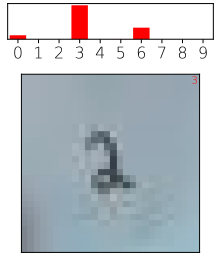

In [221]:

img2 = cv.imread('img2.jpeg')
img_2 = cv.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img_2 = img_2.reshape(1, rows*cols).astype('float32')/255


predict = model(img_2)
print(prediction)

fig = plt.figure(figsize=(3,1.2*3),constrained_layout=True) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5], figure=fig) 

ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]

ax[0].bar(range(num_classes),predict[0,:], color='r')
ax[0].set_xticks(range(num_classes))
ax[0].set_yticks([]);
ax[0].set_xlim(-0.5,9.5)

ax[1].matshow(img_2, cmap='binary')

ax[1].text(0.99,0.99,f'{np.argmax(prediction,axis=1)[0]}',horizontalalignment='right',verticalalignment='top', 
                         transform=ax[1].transAxes, color='r')
ax[1].set_xticks([]);
ax[1].set_yticks([]);

plt.imshow(img2)

tf.Tensor(
[[1.2300003e-08 7.6793287e-05 1.7791565e-03 5.0960784e-03 1.4418189e-13 9.5812273e-01 5.2487994e-06 3.4514099e-02
  4.0596712e-04 2.0211756e-10]], shape=(1, 10), dtype=float32)


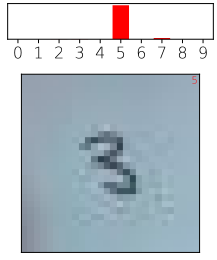

In [198]:

img3 = cv.imread('img3.jpeg')
img_3 = cv.cvtColor(img3, cv2.COLOR_BGR2GRAY)
img_3 = img_3.reshape(1, rows*cols).astype('float32')/255


predict = model(img_3)
fig = plt.figure(figsize=(3,1.2*3),constrained_layout=True) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5], figure=fig) 
ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]
ax[0].bar(range(num_classes),predict[0,:], color='r')
ax[0].set_xticks(range(num_classes))
ax[0].set_yticks([]);
ax[0].set_xlim(-0.5,9.5)

ax[1].matshow(img_1, cmap='binary')
ax[1].text(0.99,0.99,f'{np.argmax(predict,axis=1)[0]}',horizontalalignment='right',verticalalignment='top', 
                         transform=ax[1].transAxes, color='r')
ax[1].set_xticks([]);
ax[1].set_yticks([]);
plt.imshow(img3)
print(predict)

tf.Tensor(
[[1.7260597e-03 6.6768124e-14 1.1118104e-06 9.8068309e-01 1.1564890e-14 9.7771571e-04 1.6611960e-02 4.0991992e-08
  1.4919164e-07 8.5394003e-10]], shape=(1, 10), dtype=float32)


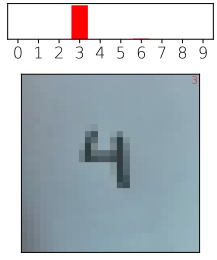

In [233]:

img4 = cv.imread('img4.jpeg')
img_4 = cv.cvtColor(img4, cv2.COLOR_BGR2GRAY)
img_4 = img_4.reshape(1, rows*cols).astype('float32')/255


predict = model(img_4)
fig = plt.figure(figsize=(3,1.2*3),constrained_layout=True) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5], figure=fig) 
ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]
ax[0].bar(range(num_classes),predict[0,:], color='r')
ax[0].set_xticks(range(num_classes))
ax[0].set_yticks([]);
ax[0].set_xlim(-0.5,9.5)

ax[1].matshow(img_1, cmap='binary')
ax[1].text(0.99,0.99,f'{np.argmax(predict,axis=1)[0]}',horizontalalignment='right',verticalalignment='top', 
                         transform=ax[1].transAxes, color='r')
ax[1].set_xticks([]);
ax[1].set_yticks([]);
plt.imshow(img4)
print(predict)

tf.Tensor(
[[1.1858862e-02 1.0428930e-13 1.4912095e-07 9.4179344e-01 9.4892037e-14 1.8872314e-03 4.4458669e-02 1.6228652e-06
  8.7089669e-09 1.7002257e-08]], shape=(1, 10), dtype=float32)


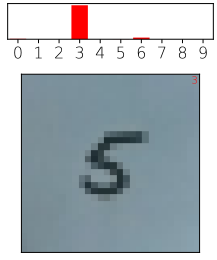

In [234]:

img5 = cv.imread('img5.jpeg')
img_5 = cv.cvtColor(img5, cv2.COLOR_BGR2GRAY)
img_5 = img_5.reshape(1, rows*cols).astype('float32')/255


predict = model(img_5)
fig = plt.figure(figsize=(3,1.2*3),constrained_layout=True) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5], figure=fig) 
ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]
ax[0].bar(range(num_classes),predict[0,:], color='r')
ax[0].set_xticks(range(num_classes))
ax[0].set_yticks([]);
ax[0].set_xlim(-0.5,9.5)

ax[1].matshow(img_1, cmap='binary')
ax[1].text(0.99,0.99,f'{np.argmax(predict,axis=1)[0]}',horizontalalignment='right',verticalalignment='top', 
                         transform=ax[1].transAxes, color='r')
ax[1].set_xticks([]);
ax[1].set_yticks([]);
plt.imshow(img5)
print(predict)

tf.Tensor(
[[3.3939034e-02 1.4485088e-12 3.3496411e-07 9.5993149e-01 1.7928564e-13 1.0659711e-03 5.0625470e-03 6.6586608e-07
  5.6336811e-09 8.8925214e-09]], shape=(1, 10), dtype=float32)


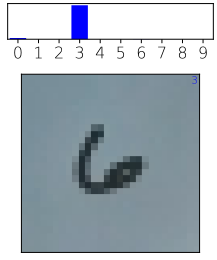

In [235]:
img6 = cv.imread('img6.jpeg')
img_6 = cv.cvtColor(img6, cv2.COLOR_BGR2GRAY)
img_6 = img_6.reshape(1, rows*cols).astype('float32')/255

prediction = model(img_6)
print(prediction)

fig = plt.figure(figsize=(3,1.2*3),constrained_layout=True) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5], figure=fig) 

ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]

ax[0].bar(range(num_classes),prediction[0,:], color='b')
ax[0].set_xticks(range(num_classes))
ax[0].set_yticks([]);
ax[0].set_xlim(-0.5,9.5)

ax[1].matshow(img_6, cmap='binary')

ax[1].text(0.99,0.99,f'{np.argmax(prediction,axis=1)[0]}',horizontalalignment='right',verticalalignment='top', 
           transform=ax[1].transAxes, color='b')
ax[1].set_xticks([]);
ax[1].set_yticks([]);
plt.imshow(img6)

tf.Tensor(
[[2.1793286e-03 2.7732783e-13 8.4099514e-07 7.3297185e-01 9.0817158e-14 9.8265363e-03 2.5502065e-01 3.0001466e-08
  7.6218959e-07 1.5373682e-09]], shape=(1, 10), dtype=float32)


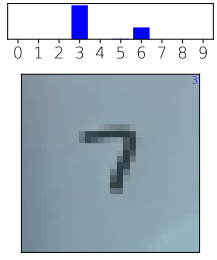

In [237]:
img7 = cv.imread('img7.jpeg')
img_7 = cv.cvtColor(img7, cv2.COLOR_BGR2GRAY)
img_7 = img_7.reshape(1, rows*cols).astype('float32')/255

prediction = model(img_7)
print(prediction)

fig = plt.figure(figsize=(3,1.2*3),constrained_layout=True) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5], figure=fig) 

ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]

ax[0].bar(range(num_classes),prediction[0,:], color='b')
ax[0].set_xticks(range(num_classes))
ax[0].set_yticks([]);
ax[0].set_xlim(-0.5,9.5)

ax[1].matshow(img_7, cmap='binary')

ax[1].text(0.99,0.99,f'{np.argmax(prediction,axis=1)[0]}',horizontalalignment='right',verticalalignment='top', 
           transform=ax[1].transAxes, color='b')
ax[1].set_xticks([]);
ax[1].set_yticks([]);
plt.imshow(img7)

tf.Tensor(
[[5.2705377e-02 1.5740399e-12 7.9388190e-07 7.5044984e-01 4.3983483e-13 8.2504069e-03 1.8859138e-01 2.0880127e-06
  1.6199444e-07 4.2589971e-08]], shape=(1, 10), dtype=float32)


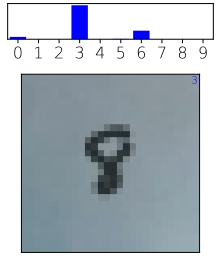

In [238]:
img8 = cv.imread('img8.jpeg')
img_8 = cv.cvtColor(img8, cv2.COLOR_BGR2GRAY)
img_8 = img_8.reshape(1, rows*cols).astype('float32')/255

prediction = model(img_8)
print(prediction)

fig = plt.figure(figsize=(3,1.2*3),constrained_layout=True) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5], figure=fig) 

ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]

ax[0].bar(range(num_classes),prediction[0,:], color='b')
ax[0].set_xticks(range(num_classes))
ax[0].set_yticks([]);
ax[0].set_xlim(-0.5,9.5)

ax[1].matshow(img_8, cmap='binary')

ax[1].text(0.99,0.99,f'{np.argmax(prediction,axis=1)[0]}',horizontalalignment='right',verticalalignment='top', 
           transform=ax[1].transAxes, color='b')
ax[1].set_xticks([]);
ax[1].set_yticks([]);
plt.imshow(img8)

tf.Tensor(
[[1.9289816e-03 4.3729072e-13 8.8359820e-06 4.8670310e-01 2.8232050e-13 1.0763265e-01 4.0371853e-01 2.2219744e-08
  7.8876274e-06 1.3406478e-08]], shape=(1, 10), dtype=float32)


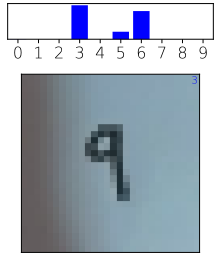

In [239]:
img9 = cv.imread('img9.jpeg')
img_9 = cv.cvtColor(img9, cv2.COLOR_BGR2GRAY)
img_9 = img_9.reshape(1, rows*cols).astype('float32')/255

prediction = model(img_9)
print(prediction)

fig = plt.figure(figsize=(3,1.2*3),constrained_layout=True) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5], figure=fig) 

ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]

ax[0].bar(range(num_classes),prediction[0,:], color='b')
ax[0].set_xticks(range(num_classes))
ax[0].set_yticks([]);
ax[0].set_xlim(-0.5,9.5)

ax[1].matshow(img_9, cmap='binary')

ax[1].text(0.99,0.99,f'{np.argmax(prediction,axis=1)[0]}',horizontalalignment='right',verticalalignment='top', 
           transform=ax[1].transAxes, color='b')
ax[1].set_xticks([]);
ax[1].set_yticks([]);
plt.imshow(img9)